In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

# Loading and Preparing Data

In [2]:
df_base = pd.read_json("/tmp/stellarpunk.history.gz", lines=True)
df_base = df_base.join(pd.json_normalize(df_base["o"]).add_prefix("o."))

In [3]:
eids = pd.Series(df_base["eid"].unique())
eids

0     4e94b2af-026e-4b9c-9f47-220554ad1b24
1     3cdd7eb0-8b69-4c40-83a3-29fbbdd1dfa7
2     57529a57-29af-4ffa-8704-28dc4cb81370
3     0731e3fd-c316-4a19-a59c-2e716e8e245e
4     5bd83d81-dce1-4b70-a2e6-8c007b008fdf
                      ...                 
81    2032f433-5b36-4507-82ce-9c1e93248c53
82    409ce920-a14c-4724-8c4a-1dc0f4daa16b
83    9f80fd55-ae65-4da7-bb4f-b8bb39065dce
84    c8060c72-c86f-4878-9dca-df4d8cbc86c8
85    7d949281-d336-4dc5-a9d4-780d59a0c852
Length: 86, dtype: object

In [4]:
eids[pd.Series(df_base["eid"].unique()).str.startswith("86e1")]

53    86e1d20f-df2b-4019-8c0d-3a4d904d5220
dtype: object

In [5]:
target_eid = df_base["eid"].unique()[53]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['86e1d20f-df2b-4019-8c0d-3a4d904d5220'], dtype=object)

In [6]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
    o_ctv = pd.DataFrame(np.vstack(df_base["o.ct_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_v.x", "o.ct_v.y"])
    o_ctcloc = pd.DataFrame(np.vstack(df_base["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_cloc.x", "o.ct_cloc.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
    o_ctv = pd.DataFrame({"o.ct_v": empty_array, "o.ct_v.x": empty_array, "o.ct_v.y": empty_array})
    o_ctcloc = pd.DataFrame({"o.ct_cloc": empty_array, "o.ct_cloc.x": empty_array, "o.ct_cloc.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctcloc, o_ctdv, o_ctv, o_tloc, o_tv, angle], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    df["o.ct_ct"] = empty_array
    df["o.ct_cradius"] = empty_array
    df["o.nd"] = empty_array
    df["o.ct_dist"] = empty_array
else:
    df["o.ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array
    df["o.t_dist"] = empty_array
else:
    df["o.t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)

In [7]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o.t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)
df["f_mag"] = df["f"].apply(lambda x:np.linalg.norm(x))

In [8]:
#df["o.ct_v.x"] = (df["o.ct_loc.x"].shift(1) - df["o.ct_loc.x"]) / (df["ts"].shift(1) - df["ts"])
#df["o.ct_v.y"] = (df["o.ct_loc.y"].shift(1) - df["o.ct_loc.y"]) / (df["ts"].shift(1) - df["ts"])

In [9]:
df

,index,p,eid,ts,loc,r,a,v,av,f,...,o.t_loc.y,o.t_v.x,o.t_v.y,angle.x,angle.y,o.ct_dist,o.t_dist,speed,o.t_speed,f_mag
0,53,SHP,86e1d20f-df2b-4019-8c0d-3a4d904d5220,0.033333,"[86154.21611206314, -113138.31520135264]",30,-2.429104,"[-17.38405255434114, -15.05218481408947]",-0.022838,"[-173813.1106065806, -98939.38842172301]",...,-220657.48253,-866.839843,-498.586690,-75.673719,-65.371923,NaN,215647.889449,22.995077,1000.000000,200000.0
1,54,SHP,86e1d20f-df2b-4019-8c0d-3a4d904d5220,0.200000,"[86150.23243745735, -113141.44226899421]",30,-2.457910,"[-31.868491310998184, -23.29711123475286]",-0.356172,"[-173813.4538850755, -98938.78536014444]",...,-220657.48253,-866.841518,-498.583777,-77.525192,-63.165216,NaN,215642.877128,39.476020,1000.000000,200000.0
2,55,SHP,86e1d20f-df2b-4019-8c0d-3a4d904d5220,0.366667,"[86143.83468757992, -113145.94348727004]",30,-2.540675,"[-46.35295867522345, -31.54198739829801]",-0.549145,"[-173813.79719264564, -98938.18224261985]",...,-220657.48253,-866.843164,-498.580915,-82.481688,-56.539996,NaN,215635.087060,56.066869,1000.000000,200000.0
3,56,SHP,86e1d20f-df2b-4019-8c0d-3a4d904d5220,0.533333,"[86135.02285766271, -113151.8188478035]",30,-2.609927,"[-60.83745464978564, -39.786813299455254]",-0.247055,"[-173814.1405385158, -98937.57905294166]",...,-220657.48253,-866.844782,-498.578103,-86.196362,-50.697013,NaN,215624.519244,72.692410,1000.000000,200000.0
4,57,SHP,86e1d20f-df2b-4019-8c0d-3a4d904d5220,0.700000,"[86123.7969429371, -113159.06834221707]",30,-2.626208,"[-75.32197923822311, -48.031588931602705]",0.085578,"[-173814.48393193525, -98936.97577485893]",...,-220657.48253,-866.846371,-498.575340,-87.010296,-49.287001,NaN,215611.173680,89.333275,1000.000000,200000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2338,2391,SHP,86e1d20f-df2b-4019-8c0d-3a4d904d5220,1266.281638,"[-73797.29482618294, -104162.06711932574]",30,-26.539817,"[120.93654409733757, 236.8269365665661]",1.098797,"[5032.445940828857, -8641.440149224849]",...,-105588.34289,-40.102593,-101.701415,16.299008,-98.662771,388.783876,1533.154153,265.918494,109.322439,10000.0
2339,2392,SHP,86e1d20f-df2b-4019-8c0d-3a4d904d5220,1266.448305,"[-73777.10588227796, -104122.64911408693]",30,-26.365981,"[121.3875833793485, 236.12663596203313]",0.981670,"[5884.7765283419185, -8085.134829517442]",...,-105588.34289,-43.053097,-108.313322,33.118292,-94.356657,366.780840,1577.236075,265.500911,116.556188,10000.0
2340,2393,SHP,86e1d20f-df2b-4019-8c0d-3a4d904d5220,1266.614971,"[-73756.83637956719, -104083.34408799422]",30,-26.208843,"[121.91084390743606, 235.47862901316253]",0.902166,"[6762.014021268174, -7367.168138177152]",...,-105588.34289,-45.817425,-114.379468,47.476322,-88.011356,349.173826,1621.254269,265.164927,123.214850,10000.0
2341,2394,SHP,86e1d20f-df2b-4019-8c0d-3a4d904d5220,1266.781638,"[-73736.47419432389, -104044.14228981714]",30,-26.062301,"[122.50680125261697, 234.8968989941834]",0.856775,"[7618.843190401965, -6477.131189042384]",...,-105588.34289,-48.390647,-119.900232,59.818694,-80.135659,336.631178,1665.222312,264.923516,129.297023,10000.0


In [10]:
df.iloc[-1]["o"]

{'o': 'stellarpunk.orders.movement.GoToLocation',
 'ct': 'cbe665a4-3ef5-442d-9f69-2e7e744f2cb8',
 'ct_loc': [-73992.94821016921, -103826.10185957132],
 'ct_v': [0.0, 0.0],
 'ct_ts': 1261.8649713957084,
 'ct_dv': [839.9396215243535, -542.6798616067545],
 'ct_tc': 0.0,
 'ct_ct': 1,
 'ct_cloc': [-73992.94821016921, -103826.10185957132],
 'ct_cradius': 300.0,
 'ct_cn': [[-73992.94821016921, -103826.10185957132]],
 'cac': False,
 'cbdr': False,
 'nd': 9.549296585513724e-09,
 'nnd': 329.71510533955245,
 't_loc': [-74359.69955877814, -105588.34288970697],
 'ad': 500.0,
 'md': 0.0,
 't_v': [-50.72654559701101, -124.77379836222123],
 'cs': False}

# Basic Ship Vitals

## Position and Heading

In [11]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=1266.948304729037, continuous_update=False, description='max_time', ma…

<function __main__.plot_location_chart(max_time)>

In [12]:
df[["loc.x", "loc.y"]].describe()

,loc.x,loc.y
count,2343.000000,2343.000000
mean,-67454.741496,-158080.967691
std,55329.097241,41874.314776
min,-123838.553962,-220451.641920
25%,-100420.010157,-192036.904451
50%,-84793.806835,-154443.885170
75%,-74824.638806,-116745.198151
max,86154.216112,-104005.031607


Text(0.5, 1.0, 'position')

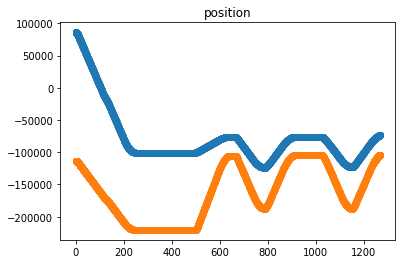

In [13]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])
plt.title("position")

Text(0.5, 1.0, 'heading and angular velocity')

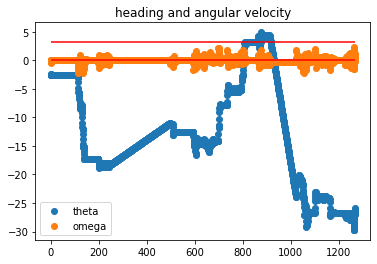

In [14]:
plt.scatter(df["ts"], df["a"], label="theta")
plt.scatter(df["ts"], df["av"], label="omega")
plt.hlines(np.pi, df["ts"].min(), df["ts"].max(), color="red")
plt.hlines(0, df["ts"].min(), df["ts"].max(), color="red")
plt.legend()
plt.title("heading and angular velocity")

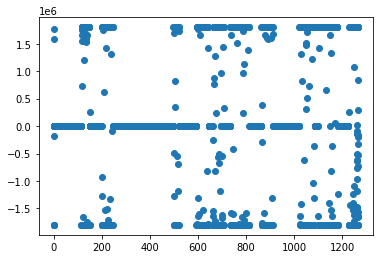

In [15]:
plt.scatter(df["ts"], df["t"])

## Velocity and Acceleration

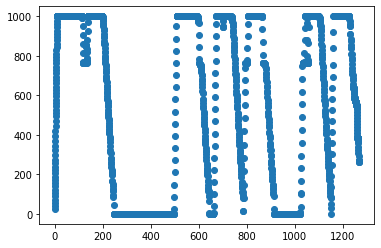

In [16]:
plt.scatter(df["ts"], df["speed"])

Text(0.5, 1.0, 'velocity')

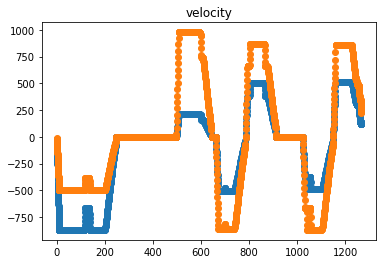

In [17]:
plt.scatter(df["ts"], df["v.x"])
plt.scatter(df["ts"], df["v.y"])
plt.title("velocity")

Text(0.5, 1.0, 'acceleration')

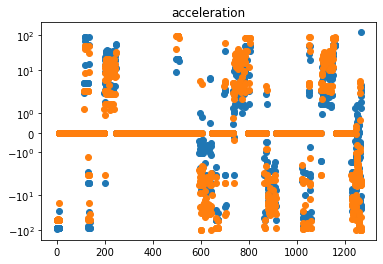

In [18]:
#plt.scatter(df["ts"], (df["v.x"] - df["v.x"].shift(-1)))#/(df["ts"]-df["ts"].shift(-1)))
plt.scatter(df["ts"], (df["v.x"].shift(1) - df["v.x"]) / (df["ts"].shift(1) - df["ts"]))
plt.scatter(df["ts"], (df["v.y"].shift(1) - df["v.y"]) / (df["ts"].shift(1) - df["ts"]))
plt.yscale("symlog")
plt.title("acceleration")

Text(0.5, 1.0, 'force')

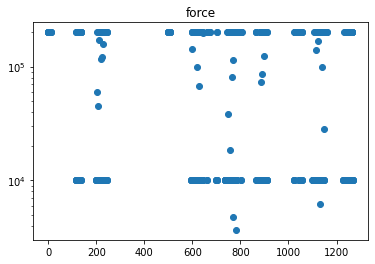

In [19]:
plt.scatter(df["ts"], df["f_mag"])
plt.yscale("log")
plt.title("force")

# Behavior Monitoring

In [20]:
[next((df.iloc[idx]["ts"] if idx is not None else None for idx, v in zip(df.index, (~df[c].isna() & df[c] == True)) if v), None) for c in ["o.ct", "o.cs", "o.cac", "o.cbdr"]]

[636.3649677083334, 1258.6149713957113, None, 1244.353996395723]

In [21]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.legend()
    plt.title("status flags")
    
    flag_cols = ["o.ct", "o.cs", "o.cac", "o.cbdr"]
    first_ts = [next((df.iloc[idx]["ts"] if idx is not None else None for idx, v in zip(df.index, (~df[c].isna() & df[c] == True)) if v), None) for c in flag_cols]
    for c, ts in zip(flag_cols, first_ts):
        print(f'first {c}: {ts}')

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=1266.9149…

<function __main__.plot_collision_info(hist_length, max_time)>

### Target Location

In [22]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"ts": ["count", "min", "max"], "o.t_dist": ["min","max"]})
else:
    x = "no location target"
x

ts                              o.t_dist  \
                              count          min          max         min   
o.t_loc.x      o.t_loc.y                                                    
-124039.419102 -187777.505163   211   661.583811   785.567521  399.076370   
-123262.616810 -187809.100988   209  1022.127953  1149.696797  424.590478   
-100777.966459 -220657.482530   640     0.033333   246.101652  424.138637   
-75767.227493  -104129.306455   194   786.240126   912.329907  449.640076   
-75600.713323  -104635.478992   239   497.968874   644.361186  410.372155   
-74359.699559  -105588.342890   282  1150.803966  1266.948305   48.714994   

                                              
                                         max  
o.t_loc.x      o.t_loc.y                      
-124039.419102 -187777.505163   95830.622329  
-123262.616810 -187809.100988   95773.610083  
-100777.966459 -220657.482530  215647.889449  
-75767.227493  -104129.306455   96179.397513  
-75600.713323  -104635.478992  118443.134562  
-74359.699559  -105588.342890   95251.347292

In [23]:
#sample = df[(df["ts"] < 124.4) & (df["ts"] > 120)]
def plot_target_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.t_dist"])
    plt.hlines(1500, sample["ts"].min(), sample["ts"].max(), color="green")
    plt.hlines(1500*0.9, sample["ts"].min(), sample["ts"].max(), color="red")
    #plt.ylim(0,1500)
    plt.title("distance to target")
    print(sample["o.t_dist"].min(),sample[df["ts"] > sample["ts"].max()-1]["o.t_dist"].min())

ipywidgets.interact(
    plot_target_distance,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=1266.9149…

<function __main__.plot_target_distance(hist_length, max_time)>

In [24]:
def plot_desired_speed(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["speed"], label="actual speed")
    plt.scatter(sample["ts"], sample["o.t_speed"], label="desired speed")
    plt.legend()
    plt.title("speed and desired speed to target")
    plt.ylim(0)

ipywidgets.interact(
    plot_desired_speed,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=1266.9149…

<function __main__.plot_desired_speed(hist_length, max_time)>

Text(0.5, 1.0, 'desired speed delta')

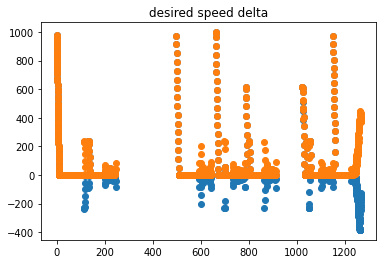

In [25]:
plt.scatter(df["ts"], df["o.t_speed"] - df["speed"])
plt.scatter(df["ts"], np.linalg.norm(np.array((df["o.t_v.x"] - df["v.x"], df["o.t_v.y"] - df["v.y"])), axis=0))
plt.title("desired speed delta")

## Collision Avoidance

In [26]:
def show_collision_threats(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    if np.any(~sample["o.ct"].isna()):
        x = sample.groupby("o.ct").agg({"ts": ["count", "min", "max"], "o.ct_dist": ["min","max"]})
    else:
        x = "no collision threats"
    return x
ipywidgets.interact(
    show_collision_threats,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=1266.9149…

<function __main__.show_collision_threats(hist_length, max_time)>

In [27]:
def plot_collision_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dist"])
    plt.hlines(60+500+500, sample["ts"].min(), sample["ts"].max(), color="green")
    plt.hlines(60+500, sample["ts"].min(), sample["ts"].max(), color="orange")
    plt.hlines(330, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.hlines(60, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.ylim(0)
    plt.title("distance to collision threat")
    print(sample["o.ct_dist"].min())

ipywidgets.interact(
    plot_collision_distance,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=1266.9149…

<function __main__.plot_collision_distance(hist_length, max_time)>

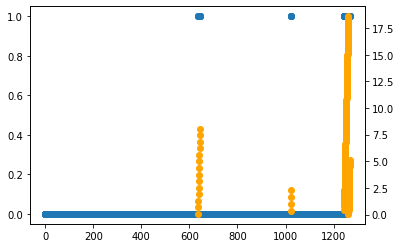

In [28]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df["ts"], 1-df["o.ct"].isna().astype(int))
ax2.scatter(df["ts"], df["ts"] - df["o.ct_ts"], color="orange")

#ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)

In [29]:
def plot_num_coalesced_threats(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_ct"])
    plt.title("number of coalesced threats")
    plt.show()

ipywidgets.interact(
    plot_num_coalesced_threats,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)  

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=1266.9149…

<function __main__.plot_num_coalesced_threats(hist_length, max_time)>

Text(0.5, 1.0, 'collision threat radius')

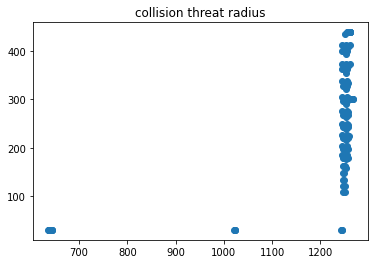

In [30]:
plt.scatter(df["ts"], df["o.ct_cradius"])
plt.title("collision threat radius")

In [31]:
def plot_neighborhood_size(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.nd"]*np.pi*10000**2)
    plt.title("neighborhood size (10km^2)")
    plt.show()

ipywidgets.interact(
    plot_neighborhood_size,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=1266.9149…

<function __main__.plot_neighborhood_size(hist_length, max_time)>

In [32]:
def plot_collision_dv(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dv.x"])
    plt.scatter(sample["ts"], sample["o.ct_dv.y"])
    plt.title("collision avoidance velocity")

ipywidgets.interact(
    plot_collision_dv,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=1266.9149…

<function __main__.plot_collision_dv(hist_length, max_time)>

# History Visualization

## Position and Velocity

In [33]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max(), sampling_interval=50, show_tloc=True, show_tv=True, show_ctdv=True, show_v=True):
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::sampling_interval]
    if show_v:
        plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], label="v")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    if show_ctdv:
        plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"]+ctdv_df["v.x"], ctdv_df["o.ct_dv.y"]+ctdv_df["v.y"], label="ctdv", color="orange")
    if show_tv:
        plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    
    plt.quiver(sample["o.ct_loc.x"], sample["o.ct_loc.y"], sample["o.ct_v.x"], sample["o.ct_v.y"])
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(df["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
        
        t_next = 10
        x, y = ct.iloc[-1]["o.ct_loc.x"], ct.iloc[-1]["o.ct_loc.y"]
        x_next, y_next = ct.iloc[-1]["o.ct_loc.x"]+ct.iloc[-1]["o.ct_v.x"]*t_next, ct.iloc[-1]["o.ct_loc.y"]+ct.iloc[-1]["o.ct_v.y"]*t_next
        if not np.allclose((x, y), (x_next, y_next)):
            plt.axline((x,y),(x_next,y_next), marker = 'x', color=c, dashes=[2,2])
    
    cloc_df = sample[~(sample["o.ct_cloc"].isna())]
    if len(cloc_df) > 0:
        cloc_x = cloc_df.iloc[-1]["o.ct_cloc.x"]
        cloc_y = cloc_df.iloc[-1]["o.ct_cloc.y"]
        cradius = cloc_df.iloc[-1]["o.ct_cradius"]
        threat_radius = plt.Circle((cloc_x, cloc_y), cradius, color="red", fill=False)
        margin = plt.Circle((cloc_x, cloc_y), cradius+30+500, color="orange", fill=False)
        margin_hist = plt.Circle((cloc_x, cloc_y), cradius+30+500*2, color="green", fill=False)
        plt.gca().add_patch(threat_radius)
        plt.gca().add_patch(margin)
        plt.gca().add_patch(margin_hist)
        print(cradius)
    
    if show_tloc:
        plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
        for ((tloc_x, tloc_y), ad, md) in sample.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"o.t_loc": "min", "o.ad":"min", "o.md":"min"}).values:
            arrival_dist = plt.Circle((tloc_x, tloc_y), ad, color="green", fill=False)
            min_dist = plt.Circle((tloc_x, tloc_y), md, color="red", fill=False)
            plt.gca().add_patch(arrival_dist)
            plt.gca().add_patch(min_dist)
            
    t_next = 10
    x, y = sample.iloc[-1]["loc.x"], sample.iloc[-1]["loc.y"]
    x_next, y_next = sample.iloc[-1]["loc.x"]+sample.iloc[-1]["v.x"]*t_next, sample.iloc[-1]["loc.y"]+sample.iloc[-1]["v.y"]*t_next
    if not np.allclose((x, y), (x_next, y_next)):
        plt.axline((x,y),(x_next,y_next),marker = 'o')
    
    plt.axis('equal')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(
    plot_collision_chart,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(step=1/60, value=df["ts"].max()+1/60, min=df["ts"].min(), max=df["ts"].max()+1/60, continuous_update=False),
    sampling_interval=ipywidgets.IntSlider(value=20, min=1, max=100, continuous_update=False),
    show_tloc=ipywidgets.Checkbox(value=True),
    show_tv=ipywidgets.Checkbox(value=True),
    show_ctdv=ipywidgets.Checkbox(value=True),
    show_v=ipywidgets.Checkbox(value=True),
)

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=1266.9149…

<function __main__.plot_collision_chart(hist_length=1266.948304729037, max_time=1266.948304729037, sampling_interval=50, show_tloc=True, show_tv=True, show_ctdv=True, show_v=True)>

## Position and Heading

In [34]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]#.iloc[::30]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="ship")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    #for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
    #    print(x)
    #    if not isinstance(x, str):
    #        continue
    #    ct = sample[sample["o.ct"] == x]
    #    plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    #plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)
    
    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=1266.9149…

<function __main__.plot_collision_chart(hist_length=1266.948304729037, max_time=1266.948304729037)>

In [35]:
for s in df.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"o.t_loc":"min", "o.ad":"min"}).values:
    print(f'{s}')

[list([-124039.41910229661, -187777.50516320395]) 500.0]
[list([-123262.61681026011, -187809.10098793148]) 500.0]
[list([-100777.96645908689, -220657.48252969116]) 500.0]
[list([-75767.22749298705, -104129.3064547928]) 500.0]
[list([-75600.71332279936, -104635.4789920685]) 500.0]
[list([-74359.69955877814, -105588.34288970697]) 500.0]


# 